# Titanic Dataset — Summary Table

| Feature        | Type               | Description |
|----------------|--------------------|-------------|
| **survived**   | Binary (0/1)       | Passenger survival (0 = no, 1 = yes). |
| **pclass**     | Categorical (1/2/3)| Passenger ticket class (proxy for socio-economic status). |
| **sex**        | Categorical        | Gender of the passenger (`male`, `female`). |
| **age**        | Continuous (float) | Age of the passenger (in years). Missing for some. |
| **sibsp**      | Integer            | Number of siblings/spouses aboard. |
| **parch**      | Integer            | Number of parents/children aboard. |
| **fare**       | Continuous (float) | Ticket price (in 1912 British pounds). |
| **embarked**   | Categorical        | Port of embarkation (`C` = Cherbourg, `Q` = Queenstown, `S` = Southampton). |
| **class**      | Categorical        | Passenger class (`First`, `Second`, `Third`). |
| **who**        | Categorical        | Simplified category (`man`, `woman`, `child`). |
| **adult_male** | Boolean            | Whether passenger is an adult male (`True`/`False`). |
| **deck**       | Categorical        | Cabin deck letter (`A–G` or missing). |
| **embark_town**| String             | Embarkation town name (`Cherbourg`, `Queenstown`, `Southampton`). |
| **alive**      | String             | Human-readable survival status (`yes`, `no`). |
| **alone**      | Boolean            | True if passenger had no family aboard. |


# 1. Imports

In [491]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import joblib

# 2. Load Titanic Dataset

In [492]:
import seaborn as sns
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 2.1 Checking Data Quality
Before applying feature engineering, we must evaluate the quality of the raw dataset.  
Typical checks include:

- **Missing values** → identify columns with NaNs.  
- **Duplicated entries** → verify if rows are repeated.  
- **Data types** → confirm consistency (numerical vs. categorical).  
- **Basic statistics** → detect outliers, skewness, unexpected ranges.  

In [493]:
# --- Checking Data Quality ---

# 1. Overview of data types and non-null counts
print("=== Dataset Info ===")
print(titanic.info())


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


In [494]:
# 2. Missing values summary
print("\n=== Missing Values ===")
print(titanic.isnull().sum())


=== Missing Values ===
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


In [495]:
# 3. Duplicates
print("\n=== Duplicated Rows ===")
print("Number of duplicates:", titanic.duplicated().sum())



=== Duplicated Rows ===
Number of duplicates: 107


In [510]:

# 4. Basic statistics
print("\n=== Descriptive Statistics ===")
display(titanic.describe(include="all").transpose())


=== Descriptive Statistics ===


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,891.0,NaN,NaN,NaN,29.361582,13.019697,0.42,22.0,28.0,35.0,80.0
sibsp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
embarked,891,3,S,646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,891,3,Third,491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
who,891,3,man,537,NaN,NaN,NaN,NaN,NaN,NaN,NaN


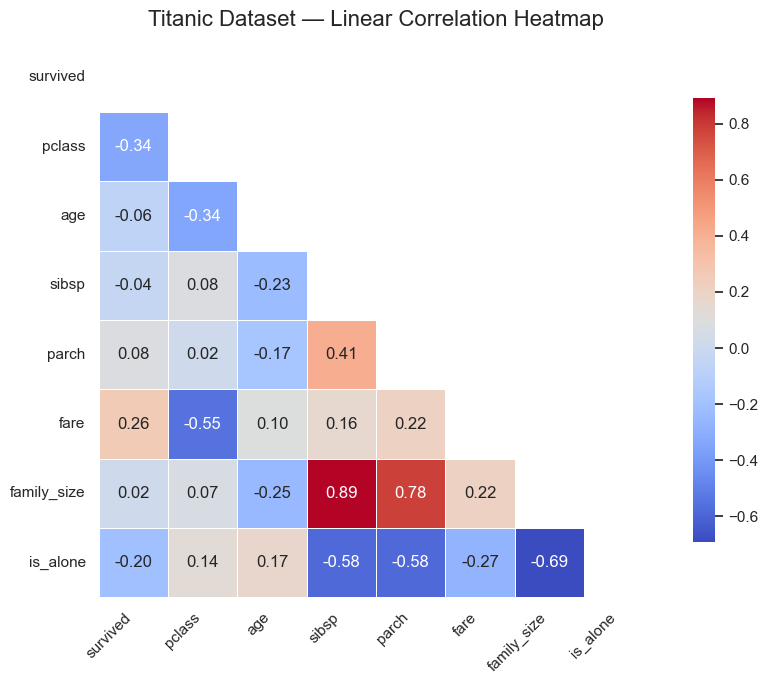

In [511]:
# Apply seaborn theme
sns.set_theme(style="white")

# Select numeric features
numeric_df = titanic.select_dtypes(include=["int64", "float64"])

# Compute correlation matrix
corr = numeric_df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(corr)

# Set up the matplotlib figure
plt.figure(figsize=(9,7))

# Draw the heatmap
sns.heatmap(
    corr, 
    mask=mask, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={"shrink": .8}, 
    linewidths=0.5, 
    square=True
)

plt.title("Titanic Dataset — Linear Correlation Heatmap", fontsize=16, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Data Cleaning

In [498]:
# Drop rows where the target is missing
titanic = titanic.dropna(subset=["survived"])

# For categorical columns: add "Unknown" as a valid category
for col in ["deck", "embark_town"]:
    titanic[col] = titanic[col].astype("category")
    titanic[col] = titanic[col].cat.add_categories("Unknown")
    titanic[col] = titanic[col].fillna("Unknown")

# For numerical column
titanic["age"] = titanic["age"].fillna(titanic["age"].median())

# For categorical 'embarked', we use the most frequent category
titanic["embarked"] = titanic["embarked"].fillna("S")


# 4. Feature Creation

In [499]:
titanic["family_size"] = titanic["sibsp"] + titanic["parch"] + 1
titanic["is_alone"] = (titanic["family_size"] == 1).astype(int)
titanic["title"] = titanic["who"].map(
    {"man": "Mr", "woman": "Mrs", "child": "Master"}
)

titanic[["survived","family_size","is_alone","title"]].head()

,survived,family_size,is_alone,title
0,0,2,0,Mr
1,1,2,0,Mrs
2,1,1,1,Mrs
3,1,2,0,Mrs
4,0,1,1,Mr


# 5. Define Features and Target

In [500]:

X = titanic[
    ["pclass","sex","age","fare","embarked","family_size","is_alone","title"]
]
y = titanic["survived"]


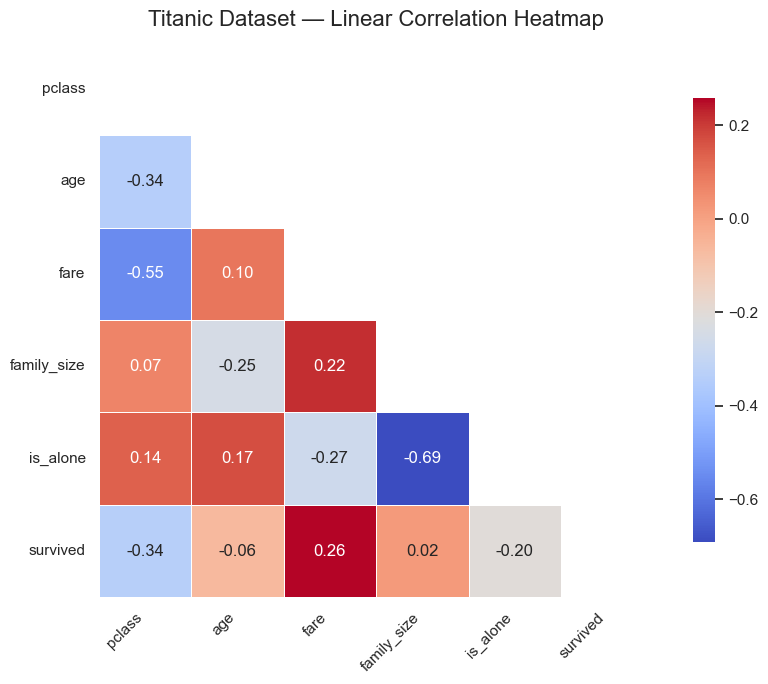

In [501]:
# Apply seaborn theme
sns.set_theme(style="white")

# Select numeric features
numeric_df = X.select_dtypes(include=["int64", "float64"]).join(y)

# Compute correlation matrix
corr = numeric_df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(corr)

# Set up the matplotlib figure
plt.figure(figsize=(9,7))

# Draw the heatmap
sns.heatmap(
    corr, 
    mask=mask, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={"shrink": .8}, 
    linewidths=0.5, 
    square=True
)

plt.title("Titanic Dataset — Linear Correlation Heatmap", fontsize=16, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

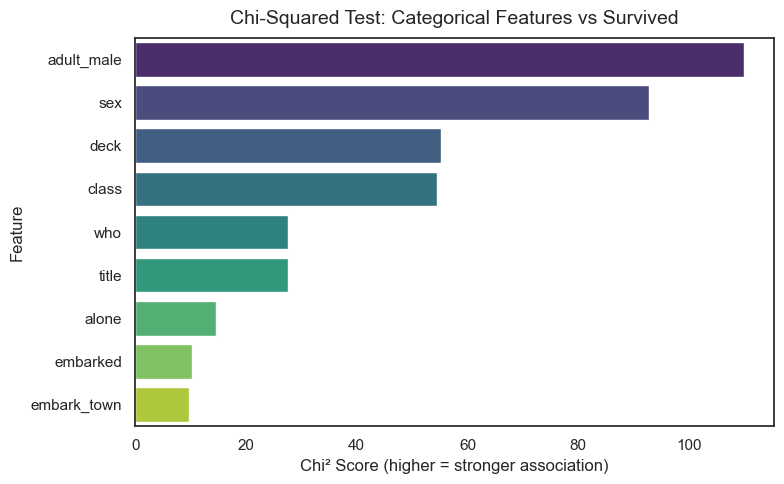

,Feature,Chi2 Score,p-value
7,alive,549.000000,2.077453e-121
4,adult_male,109.859713,1.051769e-25
0,sex,92.702447,6.077838e-22
5,deck,55.293246,1.038247e-13
2,class,54.465866,1.581715e-13
3,who,27.543638,1.535897e-07
9,title,27.543638,1.535897e-07
8,alone,14.640793,1.300685e-04
1,embarked,10.202525,1.402485e-03
6,embark_town,9.755456,1.787913e-03


In [502]:

# Select categorical features (excluding numeric)
cat_features = titanic.select_dtypes(include=["object", "category", "bool"]).copy()

# Encode categorical variables numerically
encoded = pd.DataFrame()
for col in cat_features.columns:
    le = LabelEncoder()
    encoded[col] = le.fit_transform(cat_features[col].astype(str))  # convert NaN to string

# Target variable
y = titanic["survived"].fillna(0).astype(int)

# Chi-squared test
chi_scores, p_values = chi2(encoded, y)

# Summarize results
chi_results = pd.DataFrame({
    "Feature": encoded.columns,
    "Chi2 Score": chi_scores,
    "p-value": p_values
}).sort_values("Chi2 Score", ascending=False)
# --- Plot results ---
plt.figure(figsize=(8,5))
sns.barplot(
    data=chi_results.iloc[1:, :],
    x="Chi2 Score", 
    y="Feature",
    hue = "Feature",
    palette="viridis"
)
plt.title("Chi-Squared Test: Categorical Features vs Survived", fontsize=14, pad=10)
plt.xlabel("Chi² Score (higher = stronger association)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

chi_results

# 6. Feature Selection Example

In [503]:
# Remove correlated or redundant features
# Example: drop 'is_alone' if family_size already encodes similar info
print(X.shape)
X_selected = X.drop(columns=["is_alone"])
print(X_selected.shape)

(891, 8)
(891, 7)


# 8. Train/Test Split



In [504]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(712, 7)
(179, 7)
(712,)
(179,)


# 9. Preprocessing Pipelines ---

In [505]:

numeric_features = ["age","fare","family_size"]
categorical_features = ["pclass","sex","embarked","title"]

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# 10. Full Pipeline with Logistic Regression

In [506]:
print(X_train.shape)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=100))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy (without PCA):", accuracy_score(y_test, y_pred))


(712, 7)
Accuracy (without PCA): 0.8044692737430168


# 11. Pipeline with Feature Extraction (PCA)

In [507]:
pca_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=3)),
    ("classifier", LogisticRegression(max_iter=100))
])

pca_pipeline.fit(X_train, y_train)
y_pred_pca = pca_pipeline.predict(X_test)

print("Accuracy (with PCA):", accuracy_score(y_test, y_pred_pca))

Accuracy (with PCA): 0.770949720670391


# 12. Save Pipelines (Serialization)

In [508]:

joblib.dump(clf, "titanic_feature_pipeline.pkl")
joblib.dump(pca_pipeline, "titanic_pca_pipeline.pkl")


['titanic_pca_pipeline.pkl']

# --- 13. Reload & Predict ---

In [509]:

loaded_clf = joblib.load("titanic_feature_pipeline.pkl")
print("Reloaded model accuracy:", accuracy_score(y_test, loaded_clf.predict(X_test)))


Reloaded model accuracy: 0.8044692737430168


# 14. Summary
Key Takeaways:
- Feature Engineering includes creating new variables (family_size, titles).
- Feature Selection removes redundant variables.
- Feature Extraction (PCA) transforms data into lower dimensions.
- Pipelines ensure reproducibility and consistency in MLOps.
- Serialization (joblib) allows deployment-ready models.

